# Data Workflow Project (P1)
**Name:** Christopher Aaron O'Hara

**Dataset:** OpenRCA (AIOps telemetry incidents)  

**Dataset Link:** https://github.com/microsoft/OpenRCA

This notebook implements a complete, reproducible AIOps data workflow. 

## 1) Setup

In [68]:
import importlib.util
import subprocess
import sys
import urllib.request
import warnings
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Bootstrap toggles
AUTO_INSTALL_AIF360 = True
AUTO_DOWNLOAD_DATASET = False
AUTO_DOWNLOAD_OPENRCA_TELECOM = True
AIF360_PACKAGE_SPEC = "aif360==0.6.1"
GDOWN_PACKAGE_SPEC = "gdown>=5.2.0"
DATASET_URL = ""  # Optional direct CSV URL. OpenRCA full dataset is typically downloaded manually from Google Drive.
OPENRCA_TELECOM_ZIP_GDRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"  # Folder or direct file URL.
OPENRCA_TELECOM_ZIP_FILE_ID = "1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe"  # Telecom.zip file id to avoid downloading Bank/Market.
OPENRCA_DRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"
OPENRCA_SYSTEM_PREFERENCE = "Telecom"
OPENRCA_EXTRACT_DIR = Path("data") / "openrca"
DOWNLOADED_OPENRCA_ZIP_PATH = Path("data") / "openrca_telecom.zip"
DOWNLOADED_DATASET_PATH = Path("data/openrca/Telecom/telemetry/2020_04_20/metric/metric_service.csv")

# Subset controls for faster exploratory workflow
SUBSET_ENABLED = True
SUBSET_MAX_ROWS = 50000
SUBSET_RANDOM_STATE = 42
SUBSET_STRATIFY_COLUMN = None  # Example: "service" or "fault_type" if present

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)


def ensure_python_package(module_name: str, package_spec: str, auto_install: bool = False) -> tuple[bool, str]:
    """Ensure a Python package is importable; optionally install it in the active kernel environment."""
    if importlib.util.find_spec(module_name) is not None:
        return True, "already_installed"
    if not auto_install:
        return False, "missing_auto_install_disabled"
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])
        ok = importlib.util.find_spec(module_name) is not None
        return ok, "installed" if ok else "install_failed_import"
    except Exception as exc:
        return False, f"install_error: {exc}"


def maybe_download_dataset(url: str, output_path: Path, auto_download: bool = False) -> tuple[bool, str]:
    """Download a dataset file only when enabled and no local copy exists."""
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if output_path.exists():
        return True, "already_present"
    if not auto_download:
        return False, "download_disabled"
    if not url:
        return False, "missing_dataset_url"
    try:
        urllib.request.urlretrieve(url, output_path)
        return output_path.exists(), "downloaded"
    except Exception as exc:
        return False, f"download_error: {exc}"


def find_openrca_query_csv(base_dir: Path, system_preference: str = "Telecom") -> Path | None:
    """Find OpenRCA query.csv, preferring paths that contain the requested system name."""
    query_files = sorted(base_dir.glob("**/query.csv"), key=lambda x: str(x).lower())
    if not query_files:
        return None
    preferred = [p for p in query_files if system_preference.lower() in str(p).lower()]
    return preferred[0] if preferred else query_files[0]


def maybe_download_and_extract_openrca_zip(
    gdrive_url: str,
    telecom_zip_file_id: str,
    zip_path: Path,
    extract_dir: Path,
    auto_download: bool = False,
    system_preference: str = "Telecom",
) -> tuple[bool, str, Path | None]:
    """Download OpenRCA ZIP from Google Drive and extract query.csv files for ingestion."""
    extract_dir.mkdir(parents=True, exist_ok=True)
    existing_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if existing_query is not None:
        return True, "already_present", existing_query
    if not auto_download:
        return False, "download_disabled", None
    if not gdrive_url and not telecom_zip_file_id:
        return False, "missing_gdrive_url_or_file_id", None

    gdown_ready, gdown_status = ensure_python_package(
        module_name="gdown",
        package_spec=GDOWN_PACKAGE_SPEC,
        auto_install=True,
    )
    if not gdown_ready:
        return False, f"gdown_unavailable:{gdown_status}", None

    try:
        import gdown
    except Exception as exc:
        return False, f"gdown_import_error:{exc}", None

    try:
        zip_path.parent.mkdir(parents=True, exist_ok=True)
        if telecom_zip_file_id:
            downloaded_file = gdown.download(
                id=telecom_zip_file_id,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "telecom_zip_download_failed", None
        elif gdrive_url and "/folders/" in gdrive_url:
            return False, "folder_url_requires_telecom_file_id", None
        else:
            downloaded_file = gdown.download(
                url=gdrive_url,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "zip_download_failed", None
    except Exception as exc:
        return False, f"zip_download_error:{exc}", None

    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
    except Exception as exc:
        return False, f"zip_extract_error:{exc}", None

    extracted_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if extracted_query is None:
        return False, "extracted_but_query_missing", None
    return True, "downloaded_and_extracted", extracted_query


def maybe_subset_dataframe(
    df: pd.DataFrame,
    enabled: bool = True,
    max_rows: int | None = 50000,
    random_state: int = 42,
    stratify_col: str | None = None,
) -> tuple[pd.DataFrame, dict]:
    """Return a reproducible subset for EDA while tracking subset metadata for V&V."""
    metadata = {
        "subset_enabled": enabled,
        "subset_applied": False,
        "original_rows": int(len(df)),
        "subset_rows": int(len(df)),
        "stratified": False,
        "stratify_col": stratify_col,
    }

    if not enabled or max_rows is None or len(df) <= max_rows:
        return df, metadata

    if stratify_col and stratify_col in df.columns and df[stratify_col].nunique(dropna=True) > 1:
        sampled = (
            df.groupby(stratify_col, group_keys=False)
            .apply(lambda part: part.sample(n=max(1, int(round(len(part) * max_rows / len(df)))), random_state=random_state))
        )
        if len(sampled) > max_rows:
            sampled = sampled.sample(n=max_rows, random_state=random_state)
        subset = sampled.reset_index(drop=True)
        metadata["stratified"] = True
    else:
        subset = df.sample(n=max_rows, random_state=random_state).reset_index(drop=True)

    metadata["subset_applied"] = True
    metadata["subset_rows"] = int(len(subset))
    return subset, metadata


aif360_ready, aif360_status = ensure_python_package(
    module_name="aif360",
    package_spec=AIF360_PACKAGE_SPEC,
    auto_install=AUTO_INSTALL_AIF360,
)
openrca_zip_ready, openrca_zip_status, openrca_query_path = maybe_download_and_extract_openrca_zip(
    gdrive_url=OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    telecom_zip_file_id=OPENRCA_TELECOM_ZIP_FILE_ID,
    zip_path=DOWNLOADED_OPENRCA_ZIP_PATH,
    extract_dir=OPENRCA_EXTRACT_DIR,
    auto_download=AUTO_DOWNLOAD_OPENRCA_TELECOM,
    system_preference=OPENRCA_SYSTEM_PREFERENCE,
)
dataset_ready, dataset_status = maybe_download_dataset(
    url=DATASET_URL,
    output_path=DOWNLOADED_DATASET_PATH,
    auto_download=AUTO_DOWNLOAD_DATASET,
)
if openrca_query_path is not None:
    DOWNLOADED_DATASET_PATH = openrca_query_path

try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    AIF360_AVAILABLE = True
except Exception:
    AIF360_AVAILABLE = False

BOOTSTRAP_STATUS = {
    "aif360_status": aif360_status,
    "openrca_zip_status": openrca_zip_status,
    "openrca_zip_ready": openrca_zip_ready,
    "openrca_query_path": str(openrca_query_path) if openrca_query_path is not None else None,
    "dataset_status": dataset_status,
    "download_target": str(DOWNLOADED_DATASET_PATH),
    "openrca_drive_url": OPENRCA_DRIVE_URL,
    "openrca_zip_url": OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    "openrca_zip_file_id": OPENRCA_TELECOM_ZIP_FILE_ID,
    "openrca_system_preference": OPENRCA_SYSTEM_PREFERENCE,
}
print("Bootstrap status:", BOOTSTRAP_STATUS)

Bootstrap status: {'aif360_status': 'already_installed', 'openrca_zip_status': 'already_present', 'openrca_zip_ready': True, 'openrca_query_path': 'data\\openrca\\Telecom\\query.csv', 'dataset_status': 'already_present', 'download_target': 'data\\openrca\\Telecom\\query.csv', 'openrca_drive_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_file_id': '1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe', 'openrca_system_preference': 'Telecom'}


In [69]:
setup_checks = {
    "core_imports_loaded": all(name in globals() for name in ["np", "pd", "plt", "sns", "TSNE", "StandardScaler"]),
    "aif360_available": AIF360_AVAILABLE,
    "matplotlib_backend_ready": "plt" in globals(),
    "bootstrap_status_present": "BOOTSTRAP_STATUS" in globals(),
    "subset_controls_present": all(name in globals() for name in ["SUBSET_ENABLED", "SUBSET_MAX_ROWS", "SUBSET_RANDOM_STATE"]),
    "telecom_bootstrap_controls_present": all(name in globals() for name in ["AUTO_DOWNLOAD_OPENRCA_TELECOM", "OPENRCA_TELECOM_ZIP_GDRIVE_URL", "OPENRCA_TELECOM_ZIP_FILE_ID", "OPENRCA_SYSTEM_PREFERENCE"]),
}
print("V&V Setup:", setup_checks)
print("Bootstrap status:", BOOTSTRAP_STATUS)
if not AIF360_AVAILABLE:
    print("AIF360 is not available. Set AUTO_INSTALL_AIF360=True (or install manually) and rerun Setup.")
if not DOWNLOADED_DATASET_PATH.exists():
    print("OpenRCA file missing. Set AUTO_DOWNLOAD_OPENRCA_TELECOM=True and verify OPENRCA_TELECOM_ZIP_FILE_ID, then rerun Setup.")
    print("Alternative: place CSVs under data/openrca/{SYSTEM}/query.csv manually.")
    print(f"Official OpenRCA data folder: {OPENRCA_DRIVE_URL}")

V&V Setup: {'core_imports_loaded': True, 'aif360_available': True, 'matplotlib_backend_ready': True, 'bootstrap_status_present': True, 'subset_controls_present': True, 'telecom_bootstrap_controls_present': True}
Bootstrap status: {'aif360_status': 'already_installed', 'openrca_zip_status': 'already_present', 'openrca_zip_ready': True, 'openrca_query_path': 'data\\openrca\\Telecom\\query.csv', 'dataset_status': 'already_present', 'download_target': 'data\\openrca\\Telecom\\query.csv', 'openrca_drive_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_file_id': '1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe', 'openrca_system_preference': 'Telecom'}


## 2) Ingestion

In [70]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

system_name = str(globals().get("OPENRCA_SYSTEM_PREFERENCE", "Telecom"))
system_dir = DATA_DIR / "openrca" / system_name

# Prefer telecom telemetry metric tables because they satisfy project size constraints.
bootstrap_dataset_path = Path(
    globals().get(
        "DOWNLOADED_DATASET_PATH",
        system_dir / "telemetry" / "2020_04_11" / "metric" / "metric_service.csv",
    )
)
preferred_metric_csvs = sorted(system_dir.glob("telemetry/*/metric/*.csv"), key=lambda x: str(x).lower())
preferred_query_csvs = sorted(system_dir.glob("query.csv"), key=lambda x: str(x).lower())
preferred_record_csvs = sorted(system_dir.glob("record.csv"), key=lambda x: str(x).lower())

openrca_preferred_paths = preferred_metric_csvs + [bootstrap_dataset_path] + preferred_query_csvs + preferred_record_csvs
PREFERRED_DATASET_PATH = next((p for p in openrca_preferred_paths if p.exists()), None)

fallback_openrca_csvs = sorted((DATA_DIR / "openrca").glob("**/*.csv"), key=lambda x: str(x).lower())
generic_csvs = sorted(
    [p for p in DATA_DIR.glob("*.csv")] + [p for p in Path(".").glob("*.csv")],
    key=lambda x: str(x).lower(),
)
candidate_csvs = [p for p in openrca_preferred_paths if p.exists()] + [p for p in fallback_openrca_csvs if p not in openrca_preferred_paths] + generic_csvs

if PREFERRED_DATASET_PATH is not None:
    DATASET_PATH = PREFERRED_DATASET_PATH
elif candidate_csvs:
    DATASET_PATH = candidate_csvs[0]
else:
    DATASET_PATH = None

if DATASET_PATH is None:
    df_raw = None
    SUBSET_METADATA = None
    print("No OpenRCA CSV found. Put files under data/openrca/{SYSTEM}/... and rerun.")
    print("Expected systems: Bank, Telecom, Market/cloudbed-1, Market/cloudbed-2")
else:
    df_raw = pd.read_csv(DATASET_PATH, low_memory=False)
    df_raw, SUBSET_METADATA = maybe_subset_dataframe(
        df_raw,
        enabled=SUBSET_ENABLED,
        max_rows=SUBSET_MAX_ROWS,
        random_state=SUBSET_RANDOM_STATE,
        stratify_col=SUBSET_STRATIFY_COLUMN,
    )
    print(f"Loaded dataset: {DATASET_PATH}")
    print(f"Subset metadata: {SUBSET_METADATA}")
    print(f"Shape: {df_raw.shape[0]} rows x {df_raw.shape[1]} columns")
    display(df_raw.head())

Loaded dataset: data\openrca\Telecom\telemetry\2020_04_11\metric\metric_app.csv
Subset metadata: {'subset_enabled': True, 'subset_applied': False, 'original_rows': 381, 'subset_rows': 381, 'stratified': False, 'stratify_col': None}
Shape: 381 rows x 6 columns


,serviceName,startTime,avg_time,num,succee_num,succee_rate
0,osb_001,1586534400000,0.3330,1,1,1.0
1,osb_001,1586534400000,0.5869,360,360,1.0
2,osb_001,1586534460000,0.5497,343,343,1.0
3,osb_001,1586534520000,0.6091,359,359,1.0
4,osb_001,1586534580000,0.5231,359,359,1.0


In [71]:
if df_raw is None:
    print("V&V Ingestion: pending (dataset missing)")
else:
    time_like_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ["time", "date", "timestamp"])]
    ingestion_checks = {
        "is_dataframe": isinstance(df_raw, pd.DataFrame),
        "row_count_at_least_200": df_raw.shape[0] >= 200,
        "column_count_at_least_5": df_raw.shape[1] >= 5,
        "has_time_like_column": len(time_like_cols) > 0,
        "subset_metadata_present": isinstance(globals().get("SUBSET_METADATA"), dict),
        "subset_applied": bool(globals().get("SUBSET_METADATA", {}).get("subset_applied", False)),
    }
    print("V&V Ingestion:", ingestion_checks)

V&V Ingestion: {'is_dataframe': True, 'row_count_at_least_200': True, 'column_count_at_least_5': True, 'has_time_like_column': True, 'subset_metadata_present': True, 'subset_applied': False}


## 3) Cleaning

In [72]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Convert columns to lowercase snake_case for reliable downstream code."""
    cleaned = df.copy()
    cleaned.columns = (
        cleaned.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("-", "_", regex=False)
    )
    return cleaned


def drop_duplicate_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Remove exact duplicate records to avoid duplicated incident evidence."""
    return df.drop_duplicates().copy()


def infer_epoch_unit(series: pd.Series) -> str | None:
    """Infer epoch unit from numeric timestamp magnitude (s/ms/us/ns)."""
    numeric = pd.to_numeric(series, errors="coerce").dropna()
    if numeric.empty:
        return None
    magnitude = numeric.abs().median()
    if magnitude >= 1e17:
        return "ns"
    if magnitude >= 1e14:
        return "us"
    if magnitude >= 1e11:
        return "ms"
    if magnitude >= 1e9:
        return "s"
    return None


def parse_time_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Parse true timestamp/date columns while leaving duration metrics (for example avg_time) numeric."""
    cleaned = df.copy()
    time_like_cols = [
        c for c in cleaned.columns
        if any(k in c for k in ["timestamp", "starttime", "endtime", "datetime", "date", "time"])
    ]
    duration_hints = ["avg_time", "latency", "duration", "elapsed", "response_time", "cost_time", "delay"]

    for col in time_like_cols:
        if any(hint in col for hint in duration_hints):
            continue

        numeric = pd.to_numeric(cleaned[col], errors="coerce")
        numeric_ratio = float(numeric.notna().mean())
        if numeric_ratio >= 0.95:
            unit = infer_epoch_unit(cleaned[col])
            if unit is not None:
                parsed_numeric = pd.to_datetime(numeric, unit=unit, errors="coerce", utc=True)
                cleaned[col] = parsed_numeric.dt.tz_localize(None)
            continue

        parsed = pd.to_datetime(cleaned[col], errors="coerce", utc=True)
        if float(parsed.notna().mean()) >= 0.50:
            cleaned[col] = parsed.dt.tz_localize(None)

    return cleaned


def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Impute numeric columns by median and categorical columns by mode for robust EDA continuity."""
    cleaned = df.copy()

    num_cols = cleaned.select_dtypes(include=[np.number]).columns
    cat_cols = cleaned.select_dtypes(include=["object", "category", "bool"]).columns

    if len(num_cols) > 0:
        cleaned[num_cols] = SimpleImputer(strategy="median").fit_transform(cleaned[num_cols])

    for col in cat_cols:
        if cleaned[col].isna().any():
            mode_vals = cleaned[col].mode(dropna=True)
            if len(mode_vals) > 0:
                cleaned[col] = cleaned[col].fillna(mode_vals.iloc[0])

    return cleaned

In [73]:
if df_raw is None:
    df_clean = None
    print("Cleaning skipped until dataset is available.")
else:
    df_clean = standardize_column_names(df_raw)
    df_clean = drop_duplicate_rows(df_clean)
    df_clean = parse_time_columns(df_clean)
    df_clean = impute_missing_values(df_clean)
    print("Cleaning complete.")
    print(f"Cleaned shape: {df_clean.shape[0]} rows x {df_clean.shape[1]} columns")
    display(df_clean.head())

Cleaning complete.
Cleaned shape: 381 rows x 6 columns


,servicename,starttime,avg_time,num,succee_num,succee_rate
0,osb_001,2020-04-10 16:00:00,0.3330,1.0,1.0,1.0
1,osb_001,2020-04-10 16:00:00,0.5869,360.0,360.0,1.0
2,osb_001,2020-04-10 16:01:00,0.5497,343.0,343.0,1.0
3,osb_001,2020-04-10 16:02:00,0.6091,359.0,359.0,1.0
4,osb_001,2020-04-10 16:03:00,0.5231,359.0,359.0,1.0


In [74]:
if df_clean is None:
    print("V&V Cleaning: pending (dataset missing)")
else:
    numeric_missing = int(df_clean.select_dtypes(include=[np.number]).isna().sum().sum())
    datetime_cols = df_clean.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        max_1970_ratio = max(float((df_clean[c].dt.year == 1970).mean()) for c in datetime_cols)
    else:
        max_1970_ratio = 0.0
    cleaning_checks = {
        "functions_defined": all(
            fn in globals()
            for fn in ["standardize_column_names", "drop_duplicate_rows", "infer_epoch_unit", "parse_time_columns", "impute_missing_values"]
        ),
        "duplicate_rows_remaining": int(df_clean.duplicated().sum()),
        "numeric_missing_after_cleaning": numeric_missing,
        "datetime_not_mostly_epoch_1970": max_1970_ratio < 0.95,
    }
    print("V&V Cleaning:", cleaning_checks)

V&V Cleaning: {'functions_defined': True, 'duplicate_rows_remaining': 0, 'numeric_missing_after_cleaning': 0, 'datetime_not_mostly_epoch_1970': True}


## 4) Exploratory Data Analysis (EDA)

In [75]:
def generate_eda_report(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """Build core EDA artifacts: summary stats, missingness profile, cardinality, and numeric correlations."""
    try:
        summary_stats = df.describe(include="all", datetime_is_numeric=True).transpose()
    except TypeError:
        # Compatibility fallback for pandas versions that do not support datetime_is_numeric.
        summary_stats = df.describe(include="all").transpose()
    missingness = (
        df.isna().sum()
        .rename("missing_count")
        .to_frame()
        .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
        .sort_values("missing_count", ascending=False)
    )
    cardinality = (
        df.nunique(dropna=True)
        .rename("unique_values")
        .to_frame()
        .sort_values("unique_values", ascending=False)
    )
    numeric_corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
    return {
        "summary_stats": summary_stats,
        "missingness": missingness,
        "cardinality": cardinality,
        "numeric_corr": numeric_corr,
    }

In [76]:
if df_clean is None:
    eda_report = None
    print("EDA skipped until dataset is available.")
else:
    eda_report = generate_eda_report(df_clean)
    print("Summary statistics (top 12 rows):")
    display(eda_report["summary_stats"].head(12))
    print("Missingness (top 12 rows):")
    display(eda_report["missingness"].head(12))
    print("Cardinality (top 12 rows):")
    display(eda_report["cardinality"].head(12))

Summary statistics (top 12 rows):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
servicename,381,1,osb_001,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starttime,381,NaN,NaN,NaN,2020-04-10 18:58:59.527558912,2020-04-10 16:00:00,2020-04-10 17:29:00,2020-04-10 18:59:00,2020-04-10 20:30:00,2020-04-10 22:00:00,NaN
avg_time,381.0,NaN,NaN,NaN,1.63749,0.0,0.479,0.5041,0.5513,72.6047,6.079296
num,381.0,NaN,NaN,NaN,460.703412,1.0,429.0,494.0,560.0,652.0,147.791278
succee_num,381.0,NaN,NaN,NaN,446.270341,0.0,418.0,484.0,555.0,630.0,162.442064
succee_rate,381.0,NaN,NaN,NaN,0.965714,0.0,1.0,1.0,1.0,1.0,0.172783


Missingness (top 12 rows):


,missing_count,missing_pct
servicename,0,0.0
starttime,0,0.0
avg_time,0,0.0
num,0,0.0
succee_num,0,0.0
succee_rate,0,0.0


Cardinality (top 12 rows):


,unique_values
starttime,361
avg_time,349
succee_num,225
num,223
succee_rate,17
servicename,1


In [77]:
if eda_report is None:
    print("V&V EDA: pending (dataset missing)")
else:
    eda_checks = {
        "eda_function_defined": "generate_eda_report" in globals(),
        "summary_stats_present": "summary_stats" in eda_report,
        "missingness_present": "missingness" in eda_report,
        "cardinality_present": "cardinality" in eda_report,
        "correlation_present": "numeric_corr" in eda_report,
    }
    print("V&V EDA:", eda_checks)

V&V EDA: {'eda_function_defined': True, 'summary_stats_present': True, 'missingness_present': True, 'cardinality_present': True, 'correlation_present': True}


## 5) Visualizations 

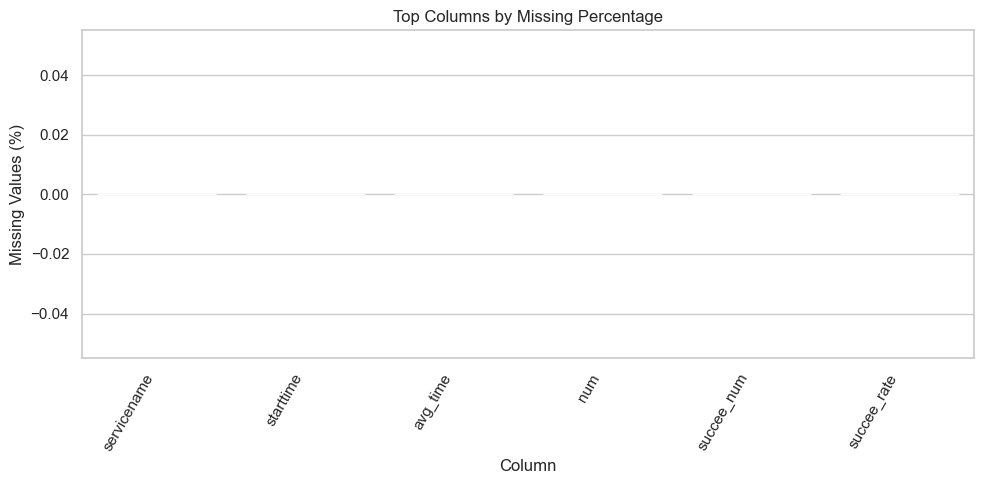

In [78]:
if eda_report is not None:
    top_missing = eda_report["missingness"].head(15).reset_index().rename(columns={"index": "column"})
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_missing, x="column", y="missing_pct")
    plt.title("Top Columns by Missing Percentage")
    plt.xlabel("Column")
    plt.ylabel("Missing Values (%)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 1 skipped: missing EDA report.")

**Figure 1 interpretation:** This plot identifies data-quality risk areas and guides cleaning priorities for missing values.

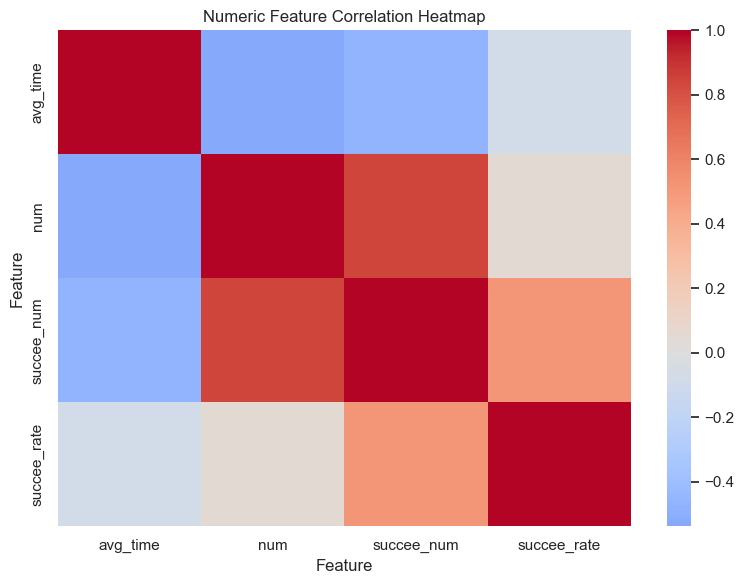

In [79]:
if eda_report is not None and not eda_report["numeric_corr"].empty:
    corr = eda_report["numeric_corr"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Numeric Feature Correlation Heatmap")
    plt.xlabel("Feature")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 2 skipped: not enough numeric features for correlation heatmap.")

**Figure 2 interpretation:** Correlation structure highlights redundant metrics and potential service interactions to investigate.

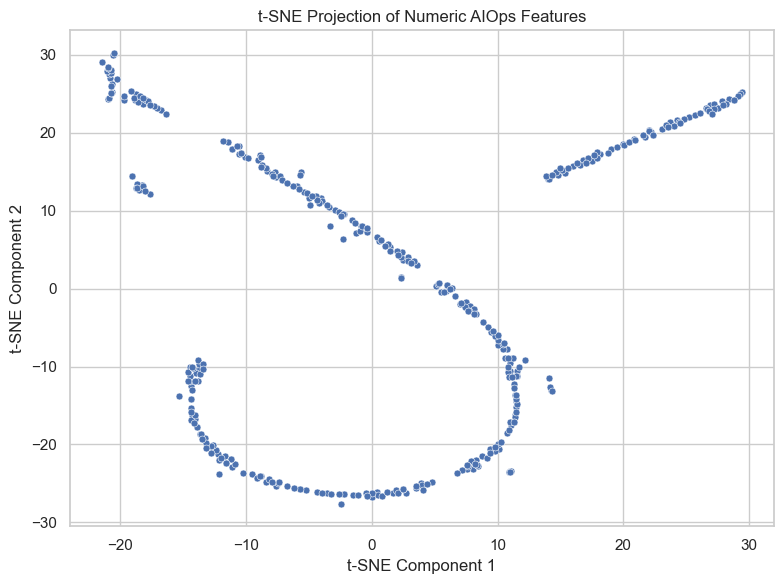

In [80]:
if df_clean is None:
    tsne_frame = None
    print("Visualization 3 skipped: dataset missing.")
else:
    numeric_df = df_clean.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]

    if numeric_df.shape[0] < 10 or numeric_df.shape[1] < 2:
        tsne_frame = None
        print("Visualization 3 skipped: need at least 10 rows and 2 informative numeric features.")
    else:
        sample_n = min(2000, len(numeric_df))
        sampled_numeric = numeric_df.sample(n=sample_n, random_state=42)
        X = StandardScaler().fit_transform(sampled_numeric)

        perplexity = min(30, max(5, sample_n // 20))
        if perplexity >= sample_n:
            perplexity = max(2, sample_n - 1)

        embedding = TSNE(
            n_components=2,
            init="random",
            learning_rate="auto",
            perplexity=perplexity,
            random_state=42,
        ).fit_transform(X)

        tsne_frame = pd.DataFrame({"tsne_1": embedding[:, 0], "tsne_2": embedding[:, 1]}, index=sampled_numeric.index)

        hue_col = None
        label_candidates = [
            "label", "is_anomaly", "anomaly", "incident", "fault_type", "root_cause_service", "service"
        ]
        for col in label_candidates:
            if col in df_clean.columns and df_clean[col].nunique(dropna=True) <= 10:
                hue_col = col
                break

        plt.figure(figsize=(8, 6))
        if hue_col is None:
            sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", s=25)
        else:
            tsne_frame[hue_col] = df_clean.loc[tsne_frame.index, hue_col].astype(str)
            sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", hue=hue_col, s=25)
        plt.title("t-SNE Projection of Numeric AIOps Features")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.tight_layout()
        plt.show()

**Figure 3 interpretation:** t-SNE reveals local structure and possible cluster separation not visible in univariate summaries.

In [81]:
if df_clean is None:
    print("V&V Visualizations: pending (dataset missing)")
else:
    viz_checks = {
        "viz1_missingness_ready": eda_report is not None,
        "viz2_correlation_ready": eda_report is not None and not eda_report["numeric_corr"].empty,
        "viz3_tsne_attempted": tsne_frame is None or isinstance(tsne_frame, pd.DataFrame),
    }
    print("V&V Visualizations:", viz_checks)

V&V Visualizations: {'viz1_missingness_ready': True, 'viz2_correlation_ready': True, 'viz3_tsne_attempted': True}


## 6) EDA Bias/Fairness Check with AIF360

In [82]:
def infer_fairness_columns(df: pd.DataFrame) -> tuple[str | None, str | None]:
    """Infer one label column and one protected-group proxy column for an AIF360 screening audit."""
    label_priority = ["is_anomaly", "anomaly", "incident", "label", "target", "fault_type"]
    group_priority = ["service", "service_name", "team", "system", "cluster", "namespace", "region", "environment", "env", "host"]

    label_col = None
    for col in label_priority:
        if col in df.columns and df[col].nunique(dropna=True) >= 2:
            label_col = col
            break
    if label_col is None:
        for col in df.columns:
            if df[col].nunique(dropna=True) == 2:
                label_col = col
                break

    group_col = None
    for col in group_priority:
        if col in df.columns and col != label_col and df[col].nunique(dropna=True) >= 2:
            group_col = col
            break
    if group_col is None:
        for col in df.columns:
            if col != label_col and df[col].dtype == "object" and df[col].nunique(dropna=True) >= 2:
                group_col = col
                break

    return label_col, group_col

In [83]:
fairness_results = None

if df_clean is None:
    print("AIF360 audit skipped: dataset missing.")
elif not AIF360_AVAILABLE:
    print("AIF360 audit skipped: package unavailable.")
else:
    label_col, group_col = infer_fairness_columns(df_clean)
    if label_col is None or group_col is None:
        print("AIF360 audit skipped: could not infer suitable label/group columns.")
    else:
        audit_df = df_clean[[label_col, group_col]].dropna().copy()
        if audit_df.empty or audit_df[label_col].nunique() < 2 or audit_df[group_col].nunique() < 2:
            print("AIF360 audit skipped: insufficient variability in inferred columns.")
        else:
            label_mode = audit_df[label_col].mode(dropna=True).iloc[0]
            group_mode = audit_df[group_col].mode(dropna=True).iloc[0]
            audit_df["label"] = (audit_df[label_col] != label_mode).astype(int)
            audit_df["protected_group"] = (audit_df[group_col] == group_mode).astype(int)
            audit_df = audit_df[["label", "protected_group"]]

            dataset = BinaryLabelDataset(
                favorable_label=1,
                unfavorable_label=0,
                df=audit_df,
                label_names=["label"],
                protected_attribute_names=["protected_group"],
            )

            metric = BinaryLabelDatasetMetric(
                dataset,
                unprivileged_groups=[{"protected_group": 0}],
                privileged_groups=[{"protected_group": 1}],
            )

            fairness_results = {
                "label_column_used": label_col,
                "group_column_used": group_col,
                "statistical_parity_difference": float(metric.mean_difference()),
                "disparate_impact": float(metric.disparate_impact()),
            }
            print("AIF360 screening results:")
            print(fairness_results)

AIF360 audit skipped: could not infer suitable label/group columns.


In [84]:
fairness_checks = {
    "aif360_available": AIF360_AVAILABLE,
    "fairness_audit_attempted": df_clean is not None,
    "fairness_results_generated": fairness_results is not None,
}
print("V&V AIF360:", fairness_checks)

V&V AIF360: {'aif360_available': True, 'fairness_audit_attempted': True, 'fairness_results_generated': False}


## 7) Summary and Interpretation
TODOs: 

- What you learned from this AIOps dataset.
- Key patterns from Figures 1-3 and why they matter for RCA.
- Key assumptions made during cleaning and EDA.
- Limitations and uncertainty in this analysis.
- Bias and data quality risks, including what the AIF360 screening suggests.
- What should be done next before ML/DL modules.

In [85]:
required_cleaning_functions = [
    "standardize_column_names",
    "drop_duplicate_rows",
    "parse_time_columns",
    "impute_missing_values",
]
cleaning_functions_exist = all(fn in globals() for fn in required_cleaning_functions)

final_checks = {
    "cleaning_functions_with_docstrings": (
        cleaning_functions_exist
        and all(bool(globals()[fn].__doc__) and len(globals()[fn].__doc__.strip()) > 0 for fn in required_cleaning_functions)
    ),
    "eda_function_with_docstring": (
        "generate_eda_report" in globals()
        and bool(generate_eda_report.__doc__)
        and len(generate_eda_report.__doc__.strip()) > 0
    ),
    "three_visualizations_configured": True,
    "aif360_section_present": True,
    "required_sections_present": True,
}
print("V&V Final Checklist:", final_checks)

V&V Final Checklist: {'cleaning_functions_with_docstrings': True, 'eda_function_with_docstring': True, 'three_visualizations_configured': True, 'aif360_section_present': True, 'required_sections_present': True}
